# Final Project

### Data Collection
Data Sources:
1. Yahoo Finance Library
    
    Collected from yfinance library
    
    Stock Market Indicators Data


2. Federal Reserve Economic Data
    
    Collected using Api Key from https://fred.stlouisfed.org/docs/api/fred/
    
    Interest Rate Data

## Data Pre-Processing
1. Merging Stock Indicators and Interest Rate data into one dataframe using the unique indetifier variable 'Date'
2. Dropping missing values
3. Using a subsection of data for animated plots to avoid putting too much load.
4. Calculating variables like growth rate from existing variables

## Data Visualizations
 1. 
- After calculating the growth rate of stock prices and interest rate over time, I have plotted the growth rate of   these series over time.
- Since my data is time series, I have first made lineplots to understand the nature of the series over time.
- I have subplotted all series in one plot to guide my analysis
- I have made autocorrelation plots of these series to check randomness in data at varying time lags.
- I have made correlation plot between IR and price of each of the 4 stocks
 2.  
#### Advanced Visualizations
- I have made interactive plots with multiple series to illustrate the relationship between prices of different       stocks and to make it easier to isolate one region or timeframe and see the trajectory of prices and interest       rate at point of interest.
- I have made animated plots to see the how these series move over time and compare to each other.


### Data Analysis
#### Time Series Analysis
1. Checking the Closing Price Series of Stocks for Stationarity. The Closing Price is being seen as a measure of the stock's value
- Using the Dicky Fuller Test for Stationarity
- Checking if the Growth Rate of Series is Stationary.
- Fitting the Stationary Series Using ARMA Model
2. Looking for a correlation between Stock Value (Price) and the Interest Rate
3. Predicting Apple's Stock Price Using Interest Rate and Prices of Other Stocks

#### Importing Requirements

In [561]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from matplotlib.pyplot import figure
import matplotlib
from matplotlib import animation
from matplotlib.animation import FuncAnimation
import yfinance as yf
%matplotlib qt
from fredapi import Fred     ## Importing Data From Fred
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.statespace.sarimax import SARIMAX
import scipy
from scipy import stats
import cufflinks as cf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import datetime
import warnings
warnings.filterwarnings("ignore")

In [562]:
print(pd.__version__)
print(np.__version__)
print(sns.__version__)
print(matplotlib.__version__)
print(scipy.__version__)
print(sklearn.__version__)
print(yf.__version__)
print(fredapi.__version__)
print(cf.__version__)
print(statsmodels.__version__)

1.4.4
1.21.5
0.11.2
3.5.2
1.9.1
1.0.2
0.1.87
0.5.0
0.17.3
0.13.2


In [563]:
## Importing Stock Data From Yahoo Finance
aapl = yf.download(tickers='AAPL', period='1000d', interval='1d',inplace=True)  # Apple
google  = yf.download(tickers='GOOG',  period='1000d', interval='1d',inplace=True)  # Google
amazon  = yf.download(tickers='AMZN',  period='1000d', interval='1d',inplace=True)  # Amazon
tesla  = yf.download(tickers='TSLA',  period='1000d', interval='1d',inplace=True) #TESLA

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [564]:
#Importing Data From Fred
fred = Fred(api_key='0e8891afccdf0b465cf8915bc862e116')
data = fred.get_series('DFF')

In [565]:
# Making a dataframe of Interest Rate data from Fred
data = pd.DataFrame(data)
data.columns = ['IR']
data = data.reset_index()
data = data.rename(columns={'index':'Date'})
data1 = data.iloc[23989:24989] #Using the last 1000 rows

### Merging the stocks data into one dataset for Analysis

In [566]:
result = pd.merge(aapl, google, on="Date")
result = result.drop(columns={'Open_x','High_x','Low_x','Open_y','High_y','Low_y','Close_x','Close_y'})
result = result.rename(columns={'Adj Close_x': 'Apple_Closing','Adj Close_y':'Google_Closing',
                        'Volume_x':'Apple_Volume','Volume_y':'Google_Volume'})
result
output = pd.merge(result,amazon, on = "Date")
output_th = pd.merge(output, tesla , on = "Date")
output_th = output_th.drop(columns={'Open_x','High_x','Low_x','Open_y','High_y','Low_y','Close_x','Close_y'})
output_th = output_th.rename(columns={'Adj Close_x': 'Amazon_Closing','Adj Close_y':'Tesla_Closing',
                            'Volume_x':'Amazon_Volume','Volume_y':'Tesla_Volume'})
final = pd.merge(output_th, data , on = "Date")
final = final.set_index('Date')


In [567]:
#Using a smaller sample of data for Animated Visualizations
final_dyn = final.iloc[700:]
final_dyn = final_dyn.reset_index()
final_dyn = final_dyn.rename(columns={'index':'Date'})

### Data Visualization

In [568]:
# Making an animated plot that shows the timeseries trend in Interest Rate in the US from 2018 to 2022

y1 = [data1['IR'][i] for i in data1.index]
t = [data1['Date'][i] for i in data1.index]
x,y=[], []
fig = plt.figure(figsize=(12,8))
axes = fig.add_subplot(1,1,1)
plt.title("Interest Rate Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Interest Rate")
def animate(i):
#     y = y1
#     x= t
    x.append((t[i]))
    y.append((y1[i]))
    plt.plot(x,y, scaley=True, scalex=True, color="blue",label='Interest Rate')
ani = FuncAnimation(fig=fig, func=animate, interval=100)
# ani.show()

In [569]:
# Making an animated plot that shows the time series trend in Closing Prices of Stocks over Time
#The plot illustrates how the stock prices change over time and relate to each other
#It illustrates how the prices move drastically change after COVID-19

a = [final_dyn['IR'][i] for i in final_dyn.index]
b = [final_dyn['Google_Closing'][i] for i in final_dyn.index]
c = [final_dyn['Apple_Closing'][i] for i in final_dyn.index]
d = [final_dyn['Amazon_Closing'][i] for i in final_dyn.index]
f = [final_dyn['Tesla_Closing'][i] for i in final_dyn.index]
e = [final_dyn['Date'][i] for i in final_dyn.index]
# labels=['Google Closing Price','Interest Rate', 'Apple Closing Price',
#         'Amazon Closing Price', 'Tesla Closing Price']
my_labels={'g':'Google Closing Price','h':'Interest Rate',
           'j':'Apple Closing Price','k':'Amazon Closing Price','l':'Tesla Closing Price'}
# plt.legend(labels,loc="best")
x1,y1,y2,y3,y4,y5=[], [],[],[],[],[]

fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (15,5))
plt.title("Interest Rate and Stocks Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
def animate(i):
    x1.append(e[i])
    y1.append((b[i]))
    y2.append((c[i]))
    y3.append((a[i]))
    y4.append((d[i]))
    y5.append((f[i]))
    g=axes.plot(x1,y1, color="blue", linewidth=0.5,label=my_labels['g'])   
    my_labels["g"] = "_nolegend_"
    h=axes.plot(x1,y3, color="red", linewidth=0.5,label=my_labels['h'])
    my_labels["h"] = "_nolegend_"
    j=axes.plot(x1,y2, color="orange", linewidth=0.5,label=my_labels['j'])
    my_labels["j"] = "_nolegend_"
    k=axes.plot(x1,y4, color="green", linewidth=0.5,label=my_labels['k'])    
    my_labels["k"] = "_nolegend_"
    l=axes.plot(x1,y5, color="purple", linewidth=0.5,label=my_labels['l']) 
    my_labels["l"] = "_nolegend_"
    axes.legend(loc='upper right', bbox_to_anchor=(1, 1))

#     return g,h,j,k,l
        
        
ani = FuncAnimation(fig=fig, func=animate, interval=40)

In [570]:
final.plot(subplots=True, figsize=(10, 12))

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>], dtype=object)

### Checking the nature of timeseries trend in stock prices and their relation with each other to be able to think about its forecasting and Time Series Analysis



In [571]:
final1 = final.iloc[:,0:8]/10
start, end = '2021-07-25', '2022-07-29'

fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(final.loc[start:end, 'IR'], marker='.', markersize=4, linestyle='-', linewidth = 0.85, label='IR', color='crimson')
ax.plot(final1.loc[start:end, 'Apple_Closing'], marker='o', markersize=4, linestyle='-',linewidth = 0.85, label='Apple Closing Price', color='red')
ax.plot(final1.loc[start:end, 'Google_Closing'], marker='o', markersize=4, linestyle='-',linewidth = 0.85, label='Google Closing Price', color='yellow')
ax.plot(final1.loc[start:end, 'Amazon_Closing'], marker='o', markersize=4, linestyle='-',linewidth = 0.85, label='Amazon Closing Price', color='green')
ax.plot(final1.loc[start:end, 'Tesla_Closing'], marker='o', markersize=4, linestyle='-',linewidth = 0.85, label='Tesla Closing Price', color='blue')


ax.set_ylabel("Price")
ax.set_xlabel("Dates")
ax.set_title("Stock Prices and Interest Rate Over Time")
ax.legend()

### Making interactive plots to be able to see more through the data by selecting the series that we want to see isolated and together with each other

In [572]:


cf.set_config_file(theme='pearl', world_readable=False)
cf.go_offline()

In [573]:
final[['Google_Closing','Apple_Closing','Amazon_Closing','Tesla_Closing','IR']].iplot(title='Closing Price of Stocks Over Time', xTitle='Dates',yTitle='Closing Price', fill=True,colors=['orange','lightgreen','yellow','lightblue','red'])


In [574]:
qf=cf.QuantFig(tesla,title='Apple Stocks Closing Price Over Time',yTitle='Closing Price',xTitle='Dates')
qf.add_sma([10,30],width=2,color=['blue','lightblue'])
qf.add_bollinger_bands()
qf.add_volume()
qf.iplot()

In [575]:
final[['Apple_Volume', 'Google_Volume','Tesla_Volume','Amazon_Volume']].iplot(title='Trends in Volumes of Stocks over time', xTitle='Dates',yTitle='Stock Volume',colors=['green','purple','red','blue'])


### Since the visualizations show that the stock closing price series and the interest rate series are not stationary series, I am plotting the growth/return of these series to see whether their growth is stationary and hence can be predicted. 
### Plotting the Growth Rate of Closing Price Series of all Stocks

In [576]:
# aapl = aapl.reset_index()
# aapl = aapl.rename(columns={'index':'Date'})
aapl['Return'] = aapl['Adj Close'].pct_change()
aapl['Return'].plot()
plt.title('Plotting Growth of the Price Series for Apple Stocks')
plt.xlabel('Date')
plt.ylabel('Price Growth Rate')
plt.show()
# plt.savefig('Apple Growth Rate Series')

In [577]:
# google = google.reset_index()
tesla['Return']=tesla['Adj Close'].pct_change()
tesla['Return'].plot()
plt.title('Plotting Growth of the Price Series for Tesla Stocks')
plt.xlabel('Date')
plt.ylabel('Price Growth Rate')
plt.show()
# plt.savefig('Tesla Growth Rate Series')

In [578]:
# google = google.reset_index()
google['Return']=google['Adj Close'].pct_change()
google['Return'].plot()
plt.title('Plotting Growth of the Price Series for Google Stocks')
plt.xlabel('Date')
plt.ylabel('Price Growth Rate')
plt.show()
# plt.savefig('Google Growth Rate Series')

In [579]:
amazon['Return']=amazon['Adj Close'].pct_change()
amazon['Return'].plot()
plt.title('Plotting Growth of the Price Series for Amazon Stocks')
plt.xlabel('Date')
plt.ylabel('Price Growth Rate')
plt.show()
# plt.savefig('Amazon Growth Rate Series')

In [580]:
data['IR_growth']=data['IR'].pct_change()
data['IR_growth'].plot()
plt.title('Plotting Growth of the Interest Rate Series')
plt.xlabel('Date')
plt.ylabel('Growth Rate')
plt.show()
# plt.savefig('Interest Rate Growth Series')

### Using Statistical Tests to Formalize the Insights
#### Checking the stationarity of stock price timeseries data using the Dicky Fuller Test that uses Null Hypothesis Significance Testing
    p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
    p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [581]:
X = final['Tesla_Closing'].values
result = adfuller(X)
print('ADF Statistic for Tesla: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic for Tesla: -1.429941
p-value: 0.567841
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


#####  p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
Closing prices of Tesla's stocks are not stationary hence we can not do forecasting on this series. 
Next we will check the growth rate of this series to see if it is stationary and then forecast its growth 

In [582]:
X = final['Apple_Closing'].values
result = adfuller(X)
print('ADF Statistic for Interest Rate: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic for Interest Rate: -1.436981
p-value: 0.564424
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


#####  p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
Closing prices of Apple's stocks are not stationary hence we can not do forecasting on this series. 
Next we will check the growth rate of this series to see if it is stationary and then forecast its growth 

In [583]:
X = final['Amazon_Closing'].values
result = adfuller(X)
print('ADF Statistic for Interest Rate: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic for Interest Rate: -1.657001
p-value: 0.453392
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


#####  p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
Closing prices of Amazon's stocks are not stationary hence we can not do forecasting on this series. 
Next we will check the growth rate of this series to see if it is stationary and then forecast its growth 

In [584]:
X = final['Google_Closing'].values
result = adfuller(X)
print('ADF Statistic for Interest Rate: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic for Interest Rate: -1.413605
p-value: 0.575737
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


#####  p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
Closing prices of Google's stocks are not stationary hence we can not do forecasting on this series. 
Next we will check the growth rate of this series to see if it is stationary and then forecast its growth 

In [585]:
X = data['IR'].values[1:]
result = adfuller(X)
print('ADF Statistic for Interest Rate: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    


ADF Statistic for Interest Rate: -2.661171
p-value: 0.081002
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


#####  p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
Interest Rate series is not stationary hence we can not do forecasting on this series. 
Next we will check the growth rate of this series to see if it is stationary and then forecast its growth 

### After running the Dicky Fuller Test on the Closing Price and Interest Rate Series, I will now run the Dicky Fuller Test on the growth of each these series to check for Stationary

In [586]:
X = aapl['Return'].values[1:]
result = adfuller(X)
print('ADF Statistic for Tesla: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic for Tesla: -10.162695
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


#### p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
   The growth rate of Apple's Stock's Closing Price is Stationary 

In [587]:
X = tesla['Return'].values[1:]
result = adfuller(X)
print('ADF Statistic for Tesla: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic for Tesla: -31.544406
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


#### p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
   The growth rate of Tesla's Stock's Closing Price is Stationary 

In [588]:
X = amazon['Return'].values[1:]
result = adfuller(X)
print('ADF Statistic for Tesla: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic for Tesla: -21.619934
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


#### p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
   The growth rate of Amazon's Stock's Closing Price is Stationary 

In [589]:
X = google['Return'].values[1:]
result = adfuller(X)
print('ADF Statistic for Tesla: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic for Tesla: -10.312054
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


#### p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
   The growth rate of Google's Stock's Closing Price is Stationary 

In [590]:
X = data['IR_growth'].values[1:]
result = adfuller(X)
print('ADF Statistic for Tesla: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic for Tesla: -15.674361
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


#### p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
   The growth rate of Interest Rate Series is Stationary 

## Checking Randomness in Data by Making Autocorrelation Plots of our Series

In [591]:
plot_acf(final['IR'], lags=50)
plt.title("Autocorrelation of Interest Rate")
# Show the AR as a plot
plt.xlabel('Lags')
plt.show()

In [592]:
plot_acf(final['Apple_Closing'], lags=50)
plt.title("Autocorrelation of Apple Closing Price")
plt.xlabel('Lags')
# Show the AR as a plot
plt.show()

In [593]:
plot_acf(final['Amazon_Closing'], lags=50)
plt.title("Autocorrelation of Amazon Closing Price")
plt.xlabel('Lags')
plt.show()

In [594]:
plot_acf(final['Tesla_Closing'], lags=50)
plt.title("Autocorrelation of Tesla Closing Price")
plt.xlabel('Lags')
plt.show()

In [595]:
plot_acf(final['Google_Closing'], lags=50)
plt.title("Autocorrelation of Google Closing Price")
plt.xlabel('Lags')
plt.show()

### Interpreting the Auto Correlation Plots
Autocorrelation is defined as the correlation of a series with a lagged version of itself. 
There is a high degree of correlation between consecutive observations.
This means that past prices are influencing future prices and we see a trend in the growth of these series.


### Fitting ARMA on Apple's Closing Price
ARMA can only be fit on stationary series.
Since we found as a result of the Dickey Fuller Test that closing price series is not stationary but its growth rate is stationary, we will fit ARMA on the Return/Growth Rate of the Closing Price of Apple's Stocks

In [596]:
apple = aapl.copy()
apple['Return']=apple['Close'].pct_change()
# apple.index = pd.DatetimeIndex(apple.index).to_period('D')

In [597]:


apple['diff'] = apple['Return'].diff().dropna()
arma = SARIMAX(apple['Return'], order=(2,0,2))

# Fit model
arma_results = arma.fit()

# Print fit summary
print(arma_results.summary())


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.40537D+00    |proj g|=  1.77193D+00


 This problem is unconstrained.



At iterate    5    f= -2.40916D+00    |proj g|=  3.95160D+00

At iterate   10    f= -2.41538D+00    |proj g|=  1.23449D-02

At iterate   15    f= -2.41542D+00    |proj g|=  1.00338D-01

At iterate   20    f= -2.41545D+00    |proj g|=  1.15005D-03

At iterate   25    f= -2.41551D+00    |proj g|=  1.19004D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     50      1     0     0   2.575D-04  -2.416D+00
  F =  -2.4155168411926371     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                               SARIMAX Results                                
Dep. Variable:                 Ret


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [598]:
arma_results.impulse_responses(10, orthogonalized=True)

0     2.155575e-02
1    -3.005313e-03
2     3.331222e-04
3    -2.193286e-04
4     3.727347e-05
5    -1.692778e-05
6     3.629563e-06
7    -1.359982e-06
8     3.329408e-07
9    -1.121991e-07
10    2.964875e-08
Name: Return, dtype: float64

In [599]:
ax = arma_results.impulse_responses(10, orthogonalized=True, impulse=[1,]).plot(figsize=(13,3))
ax.set(xlabel='t', title='Responses to a shock to `Apple Closing price`');

In [600]:

matplotlib.rcParams['figure.figsize'] = [10.0, 6.0]

model = SARIMAX(apple['Return'][700:], order=(1,0,1))
results=model.fit()

# Create the 4 diagostics plots
results.plot_diagnostics()
plt.show()


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.43584D+00    |proj g|=  5.99493D-01

At iterate    5    f= -2.43591D+00    |proj g|=  3.87780D-01

At iterate   10    f= -2.43639D+00    |proj g|=  5.18657D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     16      1     0     0   4.631D-03  -2.436D+00
  F =  -2.4363900636113693     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


### Fitting ARMA on Interest Rate Growth
ARMA can only be fit on stationary series.
Since we found as a result of the Dickey Fuller Test that closing price series is not stationary but its growth rate is stationary, we will fit ARMA on the Return/Growth Rate of the Closing Price of Apple's Stocks

In [601]:
df = data[20000:]
df

,Date,IR,IR_growth
20000,2009-04-03,0.13,-0.187500
20001,2009-04-04,0.13,0.000000
20002,2009-04-05,0.13,0.000000
20003,2009-04-06,0.14,0.076923
20004,2009-04-07,0.14,0.000000
...,...,...,...
24997,2022-12-08,3.83,0.000000
24998,2022-12-09,3.83,0.000000
24999,2022-12-10,3.83,0.000000
25000,2022-12-11,3.83,0.000000


In [602]:
df = df.reset_index(drop=True)
df['IR_growth'] = df['IR'].pct_change()

In [603]:

# df.index = pd.DatetimeIndex(df.index).to_period('D')

# df['diff'] = df['IR_growth'].diff().dropna()
arma_ir = SARIMAX(df['IR_growth'], order=(2,0,2))

# Fit model
arma_ir_results = arma_ir.fit()

# Print fit summary
print(arma_ir_results.summary())


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.84864D-01    |proj g|=  1.21172D-02


 This problem is unconstrained.



At iterate    5    f= -8.84977D-01    |proj g|=  8.11911D-03

At iterate   10    f= -8.85432D-01    |proj g|=  3.25220D-02

At iterate   15    f= -8.85515D-01    |proj g|=  3.17007D-04

At iterate   20    f= -8.85585D-01    |proj g|=  2.32012D-03

At iterate   25    f= -8.85588D-01    |proj g|=  1.65343D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     34      1     0     0   5.252D-04  -8.856D-01
  F = -0.88558825766374893     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                               SARIMAX Results                                
Dep. Variable:              IR_gro

In [604]:
ax_ir = arma_ir_results.impulse_responses(10, orthogonalized=True, impulse=[1,]).plot(figsize=(13,3))
ax_ir.set(xlabel='t', title='Responses to a shock to `Interest Rate`');


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.85002D-01    |proj g|=  4.02620D-02

At iterate    5    f= -8.85012D-01    |proj g|=  3.85366D-02

At iterate   10    f= -8.85034D-01    |proj g|=  3.47953D-03


 This problem is unconstrained.



At iterate   15    f= -8.85046D-01    |proj g|=  4.19652D-02

At iterate   20    f= -8.85289D-01    |proj g|=  1.00978D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     28      1     0     0   5.326D-07  -8.854D-01
  F = -0.88535532001158135     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


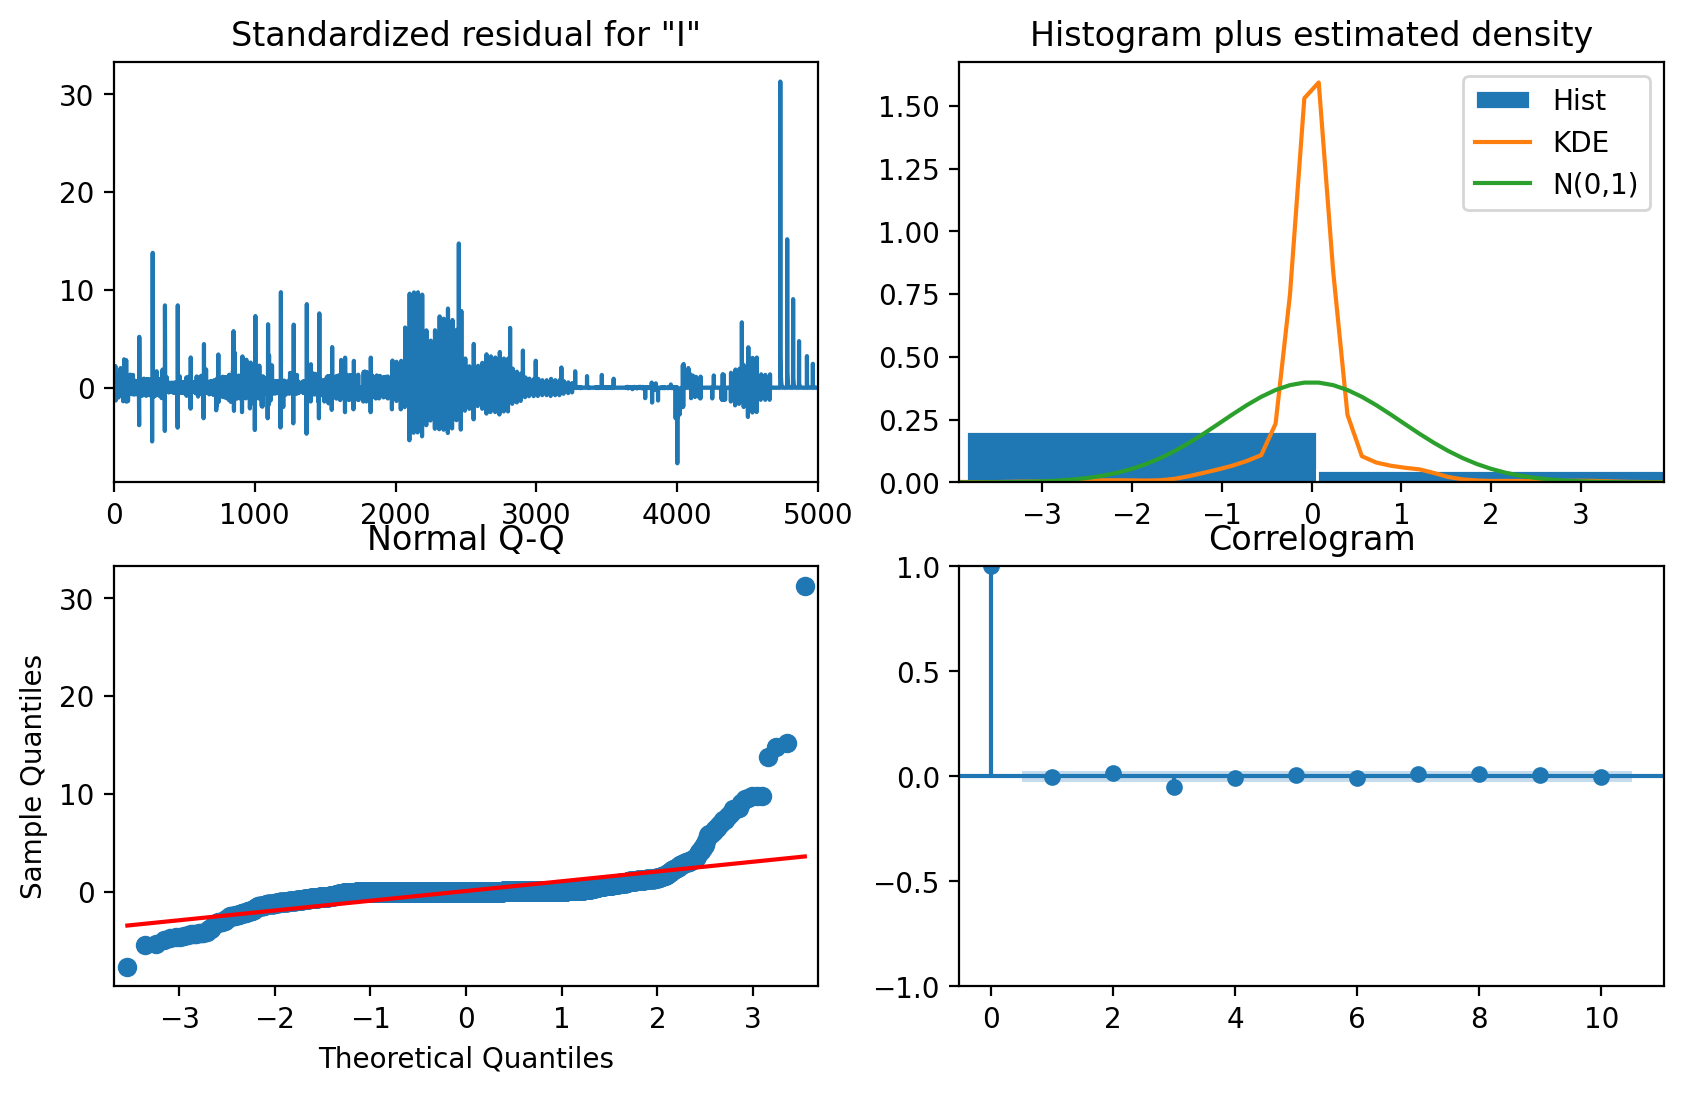

In [605]:

matplotlib.rcParams['figure.figsize'] = [10.0, 6.0]

model = SARIMAX(df['IR_growth'], order=(1,0,1))
results=model.fit()

# Create the 4 diagostics plots
results.plot_diagnostics()
# plt.show()


### Interpretation of Plot
There are no obvious patterns in the residuals
Histogram plus kde
The KDE curve is very similar to the normal distribution
Normal Q-Q: Most of the data points lie on the line
Correlogram: No correlation between lags
We can o=conclude that this is not an ARMA Process. This is a Moving Average Process

## Let us visualize the correlation between Stock Prices and Interest Rate

In [606]:
fig = plt.figure(figsize = (8, 6))
sns.regplot(data = final,x=final['Apple_Closing'], y =final['IR'])
plt.title('Correlation b/w Interest Rate and Price of Apple Stocks', weight='bold', fontsize = 15)
plt.ylabel('Interest Rate', weight='bold', fontsize = 12)
plt.xlabel('Closing Price ', weight='bold', fontsize = 12)
plt.show()
fig.savefig("Apple IR corr.png")
# 

In [607]:
fig = plt.figure(figsize = (8, 6))
sns.regplot(data = final,x=final['Google_Closing'], y =final['IR'])
plt.title('Correlation b/w Interest Rate and Price of Google Stocks', weight='bold', fontsize = 15)
plt.ylabel('Interest Rate', weight='bold', fontsize = 12)
plt.xlabel('Closing Price ', weight='bold', fontsize = 12)
plt.show()
# fig.savefig("Google IR corr.png")


In [608]:
fig = plt.figure(figsize = (8, 6))
sns.regplot(data = final,x=final['Amazon_Closing'], y =final['IR'])
plt.title('Correlation b/w Interest Rate and Price of Amazon Stocks', weight='bold', fontsize = 15)
plt.ylabel('Interest Rate', weight='bold', fontsize = 12)
plt.xlabel('Closing Price ', weight='bold', fontsize = 12)
plt.show()
# fig.savefig("Amazon IR corr.png")


In [609]:
fig = plt.figure(figsize = (8, 6))
sns.regplot(data = final,x=final['Tesla_Closing'], y =final['IR'])
plt.title('Correlation b/w Interest Rate and Price of Tesla Stocks', weight='bold', fontsize = 15)
plt.ylabel('Interest Rate', weight='bold', fontsize = 12)
plt.xlabel('Closing Price ', weight='bold', fontsize = 12)
plt.show()
# fig.savefig("Tesla IR corr.png")


## Calculating the Pearson's Correlation between Interest Rate and Stock Closing Prices

In [610]:
print(stats.pearsonr(final['Apple_Closing'], final['IR']))
print(stats.pearsonr(final['Google_Closing'], final['IR']))
print(stats.pearsonr(final['Amazon_Closing'], final['IR']))
print(stats.pearsonr(final['Tesla_Closing'], final['IR']))

PearsonRResult(statistic=-0.40422868347682883, pvalue=1.6127025221324813e-40)
PearsonRResult(statistic=-0.4657796616387924, pvalue=6.917363921902783e-55)
PearsonRResult(statistic=-0.7867005659465015, pvalue=7.332979423675656e-211)
PearsonRResult(statistic=-0.4194636510511405, pvalue=8.373971021519484e-44)


We can see that there is a negative correlation between Interest Rate and the Closing Price of stocks. We can understand this relation by looking at economic principles which states that during periods of high inflation, interest rate rises. As a result, stocks tend to fall in value owing to lower future earnings. 

### Trying to predict whether or not a stock's price increases at end of the quarter (four specific three-month periods on the financial calendar).

In [611]:
tesla.reset_index(inplace=True)
tesla = tesla.rename(columns = {'index':'Date'})

In [612]:
# splitted = aapl['Date'].str.split('/', expand=True)
tesla['Date'] = pd.to_datetime(tesla['Date'])
tesla['year'] = tesla['Date'].dt.year
tesla['day'] = tesla['Date'].dt.day
tesla['months'] = tesla['Date'].dt.month


In [613]:
tesla['is_quarter_end'] = np.where(tesla['months']%3==0,1,0)

In [614]:
tesla['price_change']  = tesla['Open'] - tesla['Close']
tesla['range']  = tesla['Low'] - tesla['High']
tesla['increase'] = np.where(tesla['Close'].shift(-1) > tesla['Close'], 1, 0)

In [615]:
X = tesla[['price_change', 'range', 'is_quarter_end']]
y = tesla['increase']
 
scaler = StandardScaler()
features = scaler.fit_transform(X)
 
X_train, X_valid, Y_train, Y_valid = train_test_split(
    X, y, test_size=0.1, random_state=2022)
print(X_train.shape, X_valid.shape)

(900, 3) (100, 3)


In [616]:
models = [LogisticRegression(), SVC(
  kernel='poly', probability=True)]
 
for i in range(2):
    models[i].fit(X_train, Y_train)
 
    print(f'{models[i]} : ')
    print('Training Accuracy : ', metrics.roc_auc_score(
    Y_train, models[i].predict_proba(X_train)[:,1]))
    print('Validation Accuracy : ', metrics.roc_auc_score(
    Y_valid, models[i].predict_proba(X_valid)[:,1]))
    print()

LogisticRegression() : 
Training Accuracy :  0.5102740579414007
Validation Accuracy :  0.5775

SVC(kernel='poly', probability=True) : 
Training Accuracy :  0.4872191018235643
Validation Accuracy :  0.44875



### Running a Logistic Regression to see how well the volume of Apple Stocks and Interest Rate explain its closing price.

In [617]:
final.reset_index(inplace=True)
final = final.rename(columns = {'index':'Date'})

In [618]:
X = final[['IR','Apple_Volume']].values
y = final['Apple_Closing'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

sklOLS_train = LinearRegression().fit(X_train, y_train)
train_pred = sklOLS_train.score(X_train, y_train)
test_pred = sklOLS_train.score(X_test, y_test)
print(train_pred, 'Training Score')
print(test_pred,'Testing Model Accuracy')

0.3051283290458582 Training Score
0.2797813712880408 Testing Model Accuracy


Our model predicted Apple's Stock Price by only 29%. This is because Interest Rate impacts Stock Prices in the long-run and not in the short-run.

### Future
For an extension of this project, I would like to use a computer with more computational power so that I can include more historic data in my model. I would like to do more time series analysis and forecasting of the Stock Indicators and compare these to other variables of the economy. I would like to see the impact of speculation by zooming into times of high economic uncertainty. For this I will first spend some time reading events of economic importance. 